# RecordLinkage Linking - 247 & Rivals

> Leveraging the RL library to determine approximate matching over a range of fields using various string methods methods.  This specifically focuses on 247 & Rivals first.

In [1]:
import json
import pandas
import time
import os
import recordlinkage
import csv
import core_constants as cc
import functions as fx

#not currently using jellyfish
import jellyfish as jf

### I don't like having all of this here - should push to functions

In [2]:
outputDir = '..//scrapedData//'
field_agg = "_"

## Load the source file dict
sourceFiles = json.loads(open('..//config//sourceFiles.json', "r").read())

## Load the id config
idConfig = json.loads(open('..//config//idConfigLink.json', "r").read())

## Load and Merge Source Files Then Create a List of Dicts for each Dataset
> This was originally set up for all of the keys in the sourcefiles.json config.  Since this file is currently only going to serve 247 & Rivals, I've hardcoded the keys to fetch

In [3]:
dataset_keys = ['sports247', 'rivals']
dfs = []
for key in dataset_keys:
    vars()[key] = fx.mergeSourceFiles (key, outputDir, sourceFiles)    
    dfs.append(vars()[key])

## Create New IDs
> This isn't elegant and I'd love to basically preprocess these collections prior to this notebook

In [4]:
fx.createNewID(idConfig['sports247'], sports247, field_agg)
fx.createNewID(idConfig['rivals'], rivals, field_agg)

## Create Dataframes
> I might move these to their own pickles so I don't constantly have to recreate these each time

In [5]:
df_sports247 = pandas.DataFrame(sports247).set_index('ID')
df_rivals = pandas.DataFrame(rivals).set_index('ID')

## Rename the indexes to something readable and predictable
> Otherwise these become 'index' and 'level_0', etc when you start to merge these.

In [6]:
df_sports247.index.name = '247_ID'
df_sports247['ID'] = df_sports247.index
df_rivals.index.name = 'rivals_ID'
df_rivals['ID'] = df_rivals.index

## Create Blockers
> I swear this isn't working.  And honestly I guess I'm ok with it not working since I'm doing string operations later on this script.  This usually takes 20+ minutes - so it is doing something...

In [7]:
indexer = recordlinkage.BlockIndex(on=['school', 'year'])
candidate_links = indexer.index(df_sports247, df_rivals)

## Define Features & Generate Comparison Vector Set

> These are all pretty straightforward.  The toughest one to assess is position - since the services don't always categorize players in the same way or have the same abbreviation for a single position.  Since this is often only a 2 or 3 letter string, I decided to do an exact match.

In [8]:
c = recordlinkage.Compare()

c.exact('ID', 'ID', label='ID')
c.string('playerName', 'playerName', method='damerau_levenshtein', label='playerName')
c.string('school', 'school', label='college')
c.string('city', 'city', label='city')
c.exact('state', 'state', label='state')
c.string('highSchool', 'highSchool', label='highSchool')
c.exact('position', 'position', label='position')
c.exact('year', 'year', label='year')

features = c.compute(candidate_links, df_sports247, df_rivals)

## Create Sum
> Final value will be between 0 and 1.  Sum represents a %confidence% level during fuzzy matching. Since an exact match on ID dictates a 100% confident match, I've removed that column from the sum.

In [9]:
features['sum'] = (features['playerName'] + features['college'] + features['city'] + features['state'] + features['highSchool'] + features['year'] + features['position'])/7

## Save to Pickle File

In [10]:
features.to_pickle("features.pkl")

## Optional: Visualize the Feature dataset

In [11]:
# Nice to see the structured outputs
features.describe()

,ID,playerName,college,city,state,highSchool,position,year,sum
count,1.052773e+06,1.052773e+06,1052773.0,1.052773e+06,1.052773e+06,1.052773e+06,1.052773e+06,1052773.0,1.052773e+06
mean,3.848123e-02,1.866900e-01,1.0,1.728699e-01,2.988754e-01,1.604008e-01,3.860186e-02,1.0,4.082054e-01
std,1.923550e-01,1.888341e-01,0.0,2.131293e-01,4.577653e-01,1.874413e-01,1.926442e-01,0.0,1.221815e-01
min,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,2.857143e-01
25%,0.000000e+00,8.333333e-02,1.0,7.692308e-02,0.000000e+00,7.142857e-02,0.000000e+00,1.0,3.344156e-01
50%,0.000000e+00,1.538462e-01,1.0,1.250000e-01,0.000000e+00,1.250000e-01,0.000000e+00,1.0,3.572503e-01
75%,0.000000e+00,2.142857e-01,1.0,2.000000e-01,1.000000e+00,1.875000e-01,0.000000e+00,1.0,4.710884e-01
max,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00


<AxesSubplot:>

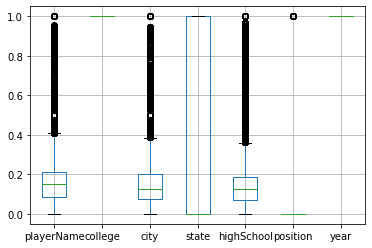

In [12]:
# Fun to run but not necessary
features.boxplot(column=['playerName', 'college', 'city', 'state', 'highSchool', 'position', 'year'])